# WandB Results Plotting

This notebook plots results from the feature-steering-RL wandb project, specifically:
- **Gemma2-2B-sparsity-sweep**: Plots vs l1_act_coeff
- **Gemma2-2B-layer-sweep**: Plots vs layer (from sae_id)

We'll create 4 plots:
1. eval/loss vs l1_act_coeff (sparsity sweep)
2. train/steering_vector/l0_norm_sparsity vs l1_act_coeff (sparsity sweep)
3. eval/loss vs layer (layer sweep + layer 12 from sparsity)
4. train/steering_vector/l0_norm_sparsity vs layer (layer sweep + layer 12 from sparsity)

In [7]:
import wandb
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from dotenv import load_dotenv
import os
import re
from matplotlib.patches import Rectangle
import matplotlib.patches as mpatches

# Load environment variables
load_dotenv()

# Set up sophisticated plotting style
plt.style.use('default')
sns.set_palette("husl")

# Enhanced matplotlib settings for publication-quality plots
plt.rcParams.update({
    'figure.figsize': (12, 8),
    'font.size': 12,
    'font.family': 'sans-serif',  # Changed from 'serif' to avoid font warning
    'text.usetex': False,
    'axes.linewidth': 1.2,
    'axes.spines.top': False,
    'axes.spines.right': False,
    'axes.grid': True,
    'grid.alpha': 0.5,  # Increased from 0.3 for better visibility
    'grid.linewidth': 1.0,  # Increased from 0.8 for better visibility
    'xtick.direction': 'out',
    'ytick.direction': 'out',
    'xtick.major.size': 6,
    'ytick.major.size': 6,
    'legend.frameon': False,
    'legend.fontsize': 11,
    'figure.dpi': 100,
    'savefig.dpi': 300,
    'savefig.bbox': 'tight',
    'savefig.pad_inches': 0.1
})

# Define a sophisticated color palette
colors = {
    'primary': '#2E86AB',      # Deep blue
    'secondary': '#A23B72',    # Deep magenta  
    'accent': '#F18F01',       # Orange
    'success': '#C73E1D',      # Deep red
    'neutral': '#6C757D',      # Gray
    'light': '#E9ECEF'         # Light gray
}

print("Enhanced plotting environment initialized!")

Enhanced plotting environment initialized!


In [8]:
# Initialize wandb API
api = wandb.Api()

# Project and entity settings - corrected based on user feedback
entity = "feature-steering-rl"  # Entity name
# We'll fetch from individual projects that correspond to the tags

print(f"Connecting to wandb entity: {entity}")
print("Will fetch from projects: Gemma2-2B-newarch-sparsitysweep and Gemma2-2B-newarch-layersweep")

Connecting to wandb entity: feature-steering-rl
Will fetch from projects: Gemma2-2B-newarch-sparsitysweep and Gemma2-2B-newarch-layersweep


## Data Collection Functions

In [9]:
def extract_layer_from_sae_id(sae_id):
    """
    Extract layer number from sae_id.
    Example: "layer_12/width_65k/average_l0_21" -> 12
    """
    if pd.isna(sae_id):
        return None
    
    match = re.search(r'layer_(\d+)', str(sae_id))  # Fixed: removed extra backslash
    if match:
        return int(match.group(1))
    return None

def get_runs_data(projects_list):
    """
    Get run data from wandb for specific projects.
    
    Args:
        projects_list: List of project names to fetch from
    
    Returns:
        DataFrame with run data
    """
    all_runs_data = []
    
    for project_name in projects_list:
        print(f"Fetching runs from project: {project_name}")
        
        runs = api.runs(f"{entity}/{project_name}")
        
        print(f"Found {len(runs)} runs")
        
        for run in runs:
            # Get final metrics from summary
            summary_metrics = run.summary
            
            # Get config values
            config = run.config
            
            run_data = {
                'run_id': run.id,
                'run_name': run.name,
                'project_name': project_name,  # Use actual project name instead of tag
                'state': run.state,
                
                # Final metrics
                'eval_loss': summary_metrics.get('eval/loss'),
                'train_l0_norm_sparsity': summary_metrics.get('train/steering_vector/l0_norm_sparsity'),
                
                # Config values
                'l1_act_coeff': config.get('training', {}).get('l1_act_coeff'),
                'sae_id': config.get('architecture', {}).get('sae', {}).get('sae_id'),
                
                # Extract layer from sae_id
                'layer': None,  # Will be computed below
            }
            
            # Extract layer number
            run_data['layer'] = extract_layer_from_sae_id(run_data['sae_id'])
            
            all_runs_data.append(run_data)
    
    df = pd.DataFrame(all_runs_data)
    
    # Filter out failed runs and runs without required data
    df = df[df['state'] == 'finished']
    
    print(f"\nTotal finished runs: {len(df)}")
    print(f"Runs with eval_loss: {df['eval_loss'].notna().sum()}")
    print(f"Runs with l0_norm_sparsity: {df['train_l0_norm_sparsity'].notna().sum()}")
    
    return df

## Fetch Data from WandB

In [10]:
# Define the projects to fetch from
projects_to_fetch = [
    "Gemma2-2B-newarch-sparsitysweep",
    "Gemma2-2B-newarch-layersweep"
]

# Fetch all run data
df = get_runs_data(projects_to_fetch)

print("\\nDataframe shape:", df.shape)
print("\\nProject breakdown:")
print(df['project_name'].value_counts())

Fetching runs from project: Gemma2-2B-newarch-sparsitysweep
Found 4 runs
Fetching runs from project: Gemma2-2B-newarch-layersweep
Found 4 runs
Fetching runs from project: Gemma2-2B-newarch-layersweep
Found 4 runs

Total finished runs: 8
Runs with eval_loss: 8
Runs with l0_norm_sparsity: 8
\nDataframe shape: (8, 9)
\nProject breakdown:
project_name
Gemma2-2B-newarch-sparsitysweep    4
Gemma2-2B-newarch-layersweep       4
Name: count, dtype: int64
Found 4 runs

Total finished runs: 8
Runs with eval_loss: 8
Runs with l0_norm_sparsity: 8
\nDataframe shape: (8, 9)
\nProject breakdown:
project_name
Gemma2-2B-newarch-sparsitysweep    4
Gemma2-2B-newarch-layersweep       4
Name: count, dtype: int64


In [11]:
# Display sample of the data
print("Sample of collected data:")
display(df.head())

print("\nData summary:")
print(df.describe())

Sample of collected data:


,run_id,run_name,project_name,state,eval_loss,train_l0_norm_sparsity,l1_act_coeff,sae_id,layer
0,mx0jlo4d,dauntless-star-1,Gemma2-2B-newarch-sparsitysweep,finished,4.197320,5207.670898,0.06,layer_12/width_65k/average_l0_21,12
1,sihchv8n,stellar-wood-2,Gemma2-2B-newarch-sparsitysweep,finished,4.420743,3538.830566,0.08,layer_12/width_65k/average_l0_21,12
2,0weaf7th,vital-wildflower-4,Gemma2-2B-newarch-sparsitysweep,finished,6.315233,3001.589600,0.20,layer_12/width_65k/average_l0_21,12
3,0lfj7yvu,legendary-elevator-5,Gemma2-2B-newarch-sparsitysweep,finished,7.229602,2755.520752,0.40,layer_12/width_65k/average_l0_21,12
4,hfdtjnml,visionary-pond-1,Gemma2-2B-newarch-layersweep,finished,5.336388,3618.915283,0.10,layer_12/width_65k/average_l0_21,12



Data summary:
       eval_loss  train_l0_norm_sparsity  l1_act_coeff      layer
count   8.000000                8.000000      8.000000   8.000000
mean    6.236752             4151.235718      0.142500  13.500000
std     1.917427             1670.352914      0.111835   5.318432
min     4.197320             2755.520752      0.060000   6.000000
25%     5.107477             2980.492554      0.095000  12.000000
50%     5.864393             3578.872925      0.100000  12.000000
75%     6.916023             4623.797363      0.125000  13.500000
max    10.169683             7740.984375      0.400000  24.000000


## Data Preparation

In [12]:
# Separate data by project type
sparsity_data = df[df['project_name'] == 'Gemma2-2B-newarch-sparsitysweep'].copy()
layer_data = df[df['project_name'] == 'Gemma2-2B-newarch-layersweep'].copy()

print(f"Sparsity sweep runs: {len(sparsity_data)}")
print(f"Layer sweep runs: {len(layer_data)}")

# For sparsity analysis, add layer 12 data from layer sweep (different l1 norm values)
layer_12_from_layer_sweep = layer_data[layer_data['layer'] == 12].copy()
if len(layer_12_from_layer_sweep) > 0:
    print(f"Adding {len(layer_12_from_layer_sweep)} layer 12 runs from layer sweep to sparsity analysis")
    # Add a note to distinguish the source
    layer_12_from_layer_sweep['source'] = 'layer-sweep'
    sparsity_data['source'] = 'sparsity-sweep'
    
    # Combine for sparsity analysis
    combined_sparsity_data = pd.concat([sparsity_data, layer_12_from_layer_sweep], ignore_index=True)
else:
    combined_sparsity_data = sparsity_data.copy()
    combined_sparsity_data['source'] = 'sparsity-sweep'

# Keep layer data separate for layer analysis (no additional data needed)
layer_data['source'] = 'layer-sweep'

print(f"Combined sparsity data: {len(combined_sparsity_data)} runs")
print(f"Layer data: {len(layer_data)} runs")

Sparsity sweep runs: 4
Layer sweep runs: 4
Adding 1 layer 12 runs from layer sweep to sparsity analysis
Combined sparsity data: 5 runs
Layer data: 4 runs


In [13]:
# Check data availability for plotting
print("Combined sparsity data availability:")
print(f"  - Runs with l1_act_coeff: {combined_sparsity_data['l1_act_coeff'].notna().sum()}")
print(f"  - Runs with eval_loss: {combined_sparsity_data['eval_loss'].notna().sum()}")
print(f"  - Runs with l0_norm_sparsity: {combined_sparsity_data['train_l0_norm_sparsity'].notna().sum()}")

print("\nLayer sweep data availability:")
print(f"  - Runs with layer info: {layer_data['layer'].notna().sum()}")
print(f"  - Runs with eval_loss: {layer_data['eval_loss'].notna().sum()}")
print(f"  - Runs with l0_norm_sparsity: {layer_data['train_l0_norm_sparsity'].notna().sum()}")

print("\nUnique l1_act_coeff values in combined sparsity data:")
print(sorted(combined_sparsity_data['l1_act_coeff'].dropna().unique()))

print("\nUnique layers in layer data:")
print(sorted(layer_data['layer'].dropna().unique()))

Combined sparsity data availability:
  - Runs with l1_act_coeff: 5
  - Runs with eval_loss: 5
  - Runs with l0_norm_sparsity: 5

Layer sweep data availability:
  - Runs with layer info: 4
  - Runs with eval_loss: 4
  - Runs with l0_norm_sparsity: 4

Unique l1_act_coeff values in combined sparsity data:
[0.06, 0.08, 0.1, 0.2, 0.4]

Unique layers in layer data:
[6, 12, 18, 24]


## Plotting Functions

In [14]:
def create_fancy_plot(data, x_col, y_col, title, xlabel, ylabel, color_col=None, plot_type='bar', force_single_color=False):
    """
    Create a sophisticated, publication-quality bar plot with enhanced styling.
    """
    # Filter out rows with missing data
    plot_data = data.dropna(subset=[x_col, y_col])
    
    if len(plot_data) == 0:
        print(f"No data available for {title}")
        return None
    
    # Create figure with enhanced styling
    fig, ax = plt.subplots(figsize=(12, 8))
    fig.patch.set_facecolor('white')
    
    if plot_type == 'bar':
        if force_single_color or not (color_col and color_col in plot_data.columns):
            # Single color bar plot with enhanced styling
            grouped_data = plot_data.groupby(x_col)[y_col].mean().sort_index()
            
            # Create bars with consistent styling
            x_positions = np.arange(len(grouped_data))
            bars = ax.bar(x_positions, grouped_data.values, 
                         width=0.7, 
                         color=colors['primary'],
                         alpha=0.8,
                         edgecolor='white',
                         linewidth=1.5)
            
            # Add subtle shadow effect without gradient
            for i, bar in enumerate(bars):
                # Add subtle shadow effect
                shadow = Rectangle((bar.get_x() + 0.02, bar.get_y() + 0.02), 
                                 bar.get_width(), bar.get_height(),
                                 facecolor='gray', alpha=0.1, zorder=0)
                ax.add_patch(shadow)
            
            # Add value labels on top of bars with 2 decimal places
            for i, (x_pos, value) in enumerate(zip(x_positions, grouped_data.values)):
                ax.text(x_pos, value + max(grouped_data.values) * 0.01, 
                       f'{value:.2f}', 
                       ha='center', va='bottom', 
                       fontweight='bold', fontsize=10,
                       color=colors['neutral'])
            
            # Set x-axis labels with better formatting
            ax.set_xticks(x_positions)
            ax.set_xticklabels([f'{x:.3f}' if isinstance(x, float) else str(x) for x in grouped_data.index],
                              fontweight='bold', fontsize=11)
        else:
            # Multi-color grouped bar plot (if needed)
            grouped_color_data = plot_data.groupby([x_col, color_col])[y_col].mean().unstack(fill_value=0)
            bars = grouped_color_data.plot(kind='bar', ax=ax, 
                                         width=0.7, 
                                         color=[colors['primary'], colors['secondary']],
                                         alpha=0.8, 
                                         edgecolor='white',
                                         linewidth=1.5,
                                         legend=False)
    
    # Enhanced axis styling
    ax.set_xlabel(xlabel, fontsize=14, fontweight='bold', color=colors['neutral'])
    ax.set_ylabel(ylabel, fontsize=14, fontweight='bold', color=colors['neutral'])
    ax.set_title(title, fontsize=16, fontweight='bold', color=colors['neutral'], pad=20)
    
    # Customize grid with increased visibility
    ax.grid(True, alpha=0.5, linestyle='-', linewidth=1.0, color=colors['light'])
    ax.set_axisbelow(True)
    
    # Remove top and right spines, enhance bottom and left
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_linewidth(1.2)
    ax.spines['left'].set_linewidth(1.2)
    ax.spines['bottom'].set_color(colors['neutral'])
    ax.spines['left'].set_color(colors['neutral'])
    
    # Enhance tick styling
    ax.tick_params(axis='both', which='major', labelsize=11, 
                   colors=colors['neutral'], width=1.2, length=6)
    ax.tick_params(axis='x', rotation=0)
    
    # Add subtle background
    ax.set_facecolor('#FAFAFA')
    
    # Adjust layout for better spacing
    plt.tight_layout()
    
    # Add a subtle border around the entire plot
    for spine in ax.spines.values():
        if spine.get_visible():
            spine.set_edgecolor(colors['neutral'])
    
    return fig

# Convenience function for backward compatibility
def create_plot(data, x_col, y_col, title, xlabel, ylabel, color_col=None, plot_type='bar', force_single_color=False):
    """Wrapper for the fancy plotting function"""
    return create_fancy_plot(data, x_col, y_col, title, xlabel, ylabel, color_col, plot_type, force_single_color)

## Plot 1: Sparsity Sweep - eval/loss vs l1_act_coeff

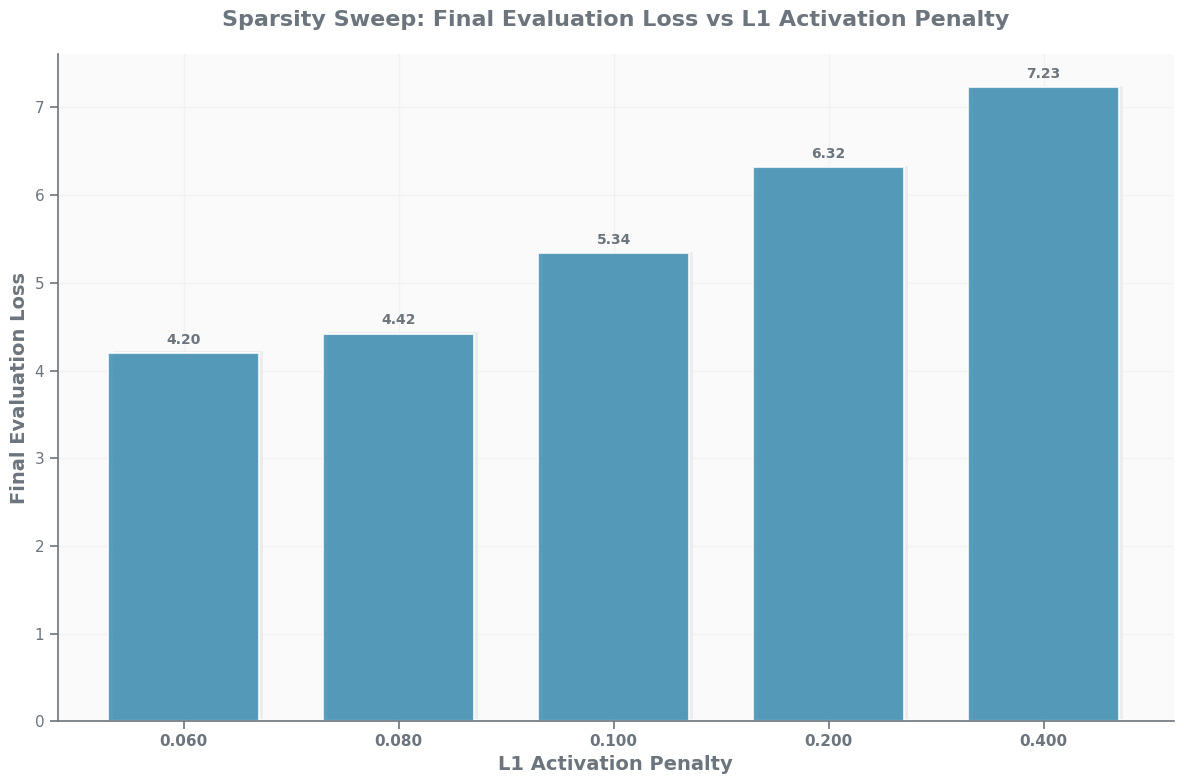


Datapoints: 5
L1 coeff range: 0.0600 to 0.4000
Eval loss range: 4.1973 to 7.2296
Source breakdown:
source
sparsity-sweep    4
layer-sweep       1
Name: count, dtype: int64


In [15]:
fig1 = create_plot(
    data=combined_sparsity_data,
    x_col='l1_act_coeff',
    y_col='eval_loss',
    title='Sparsity Sweep: Final Evaluation Loss vs L1 Activation Penalty',
    xlabel='L1 Activation Penalty',
    ylabel='Final Evaluation Loss',
    plot_type='bar',
    force_single_color=True
)

if fig1:
    plt.show()
    
    # Print some statistics
    valid_data = combined_sparsity_data.dropna(subset=['l1_act_coeff', 'eval_loss'])
    if len(valid_data) > 0:
        print(f"\nDatapoints: {len(valid_data)}")
        print(f"L1 coeff range: {valid_data['l1_act_coeff'].min():.4f} to {valid_data['l1_act_coeff'].max():.4f}")
        print(f"Eval loss range: {valid_data['eval_loss'].min():.4f} to {valid_data['eval_loss'].max():.4f}")
        print(f"Source breakdown:")
        print(valid_data['source'].value_counts())

## Plot 2: Sparsity Sweep - train/steering_vector/l0_norm_sparsity vs l1_act_coeff

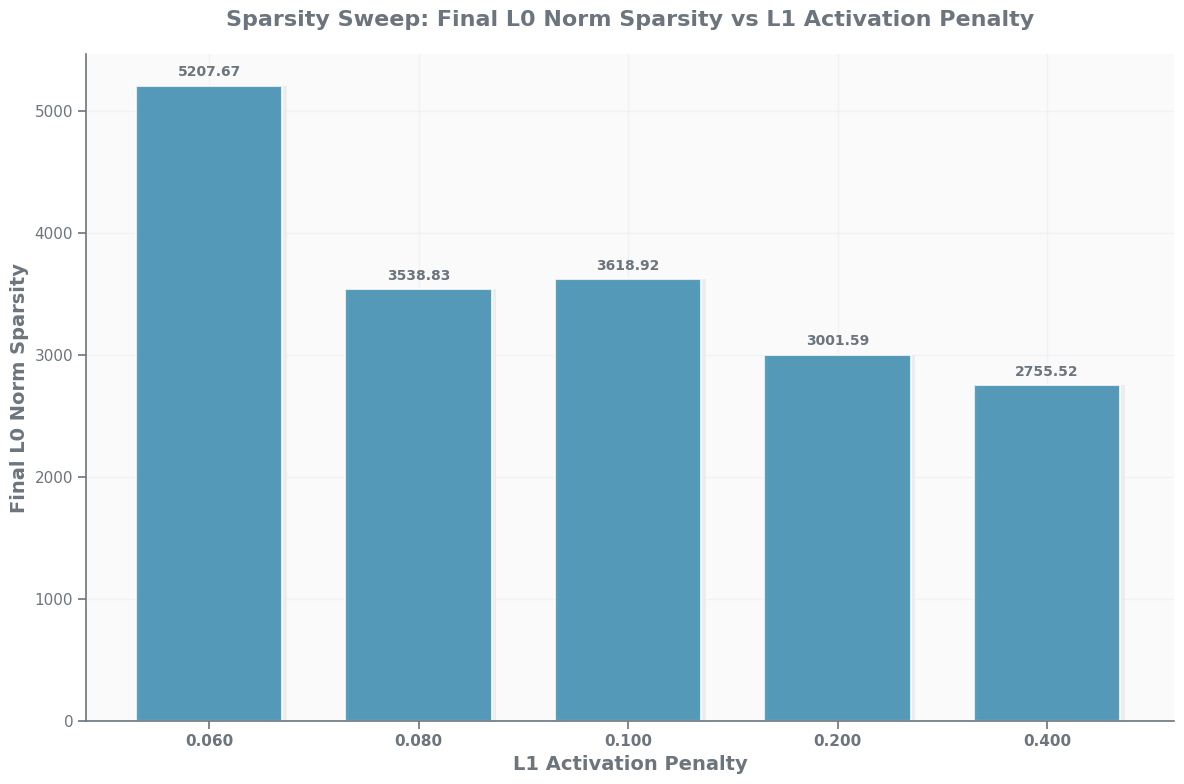


Datapoints: 5
L1 coeff range: 0.0600 to 0.4000
L0 sparsity range: 2755.5208 to 5207.6709
Source breakdown:
source
sparsity-sweep    4
layer-sweep       1
Name: count, dtype: int64


In [16]:
fig2 = create_plot(
    data=combined_sparsity_data,
    x_col='l1_act_coeff',
    y_col='train_l0_norm_sparsity',
    title='Sparsity Sweep: Final L0 Norm Sparsity vs L1 Activation Penalty',
    xlabel='L1 Activation Penalty',
    ylabel='Final L0 Norm Sparsity',
    plot_type='bar',
    force_single_color=True
)

if fig2:
    plt.show()
    
    # Print some statistics
    valid_data = combined_sparsity_data.dropna(subset=['l1_act_coeff', 'train_l0_norm_sparsity'])
    if len(valid_data) > 0:
        print(f"\nDatapoints: {len(valid_data)}")
        print(f"L1 coeff range: {valid_data['l1_act_coeff'].min():.4f} to {valid_data['l1_act_coeff'].max():.4f}")
        print(f"L0 sparsity range: {valid_data['train_l0_norm_sparsity'].min():.4f} to {valid_data['train_l0_norm_sparsity'].max():.4f}")
        print(f"Source breakdown:")
        print(valid_data['source'].value_counts())

## Plot 3: Layer Sweep - eval/loss vs layer

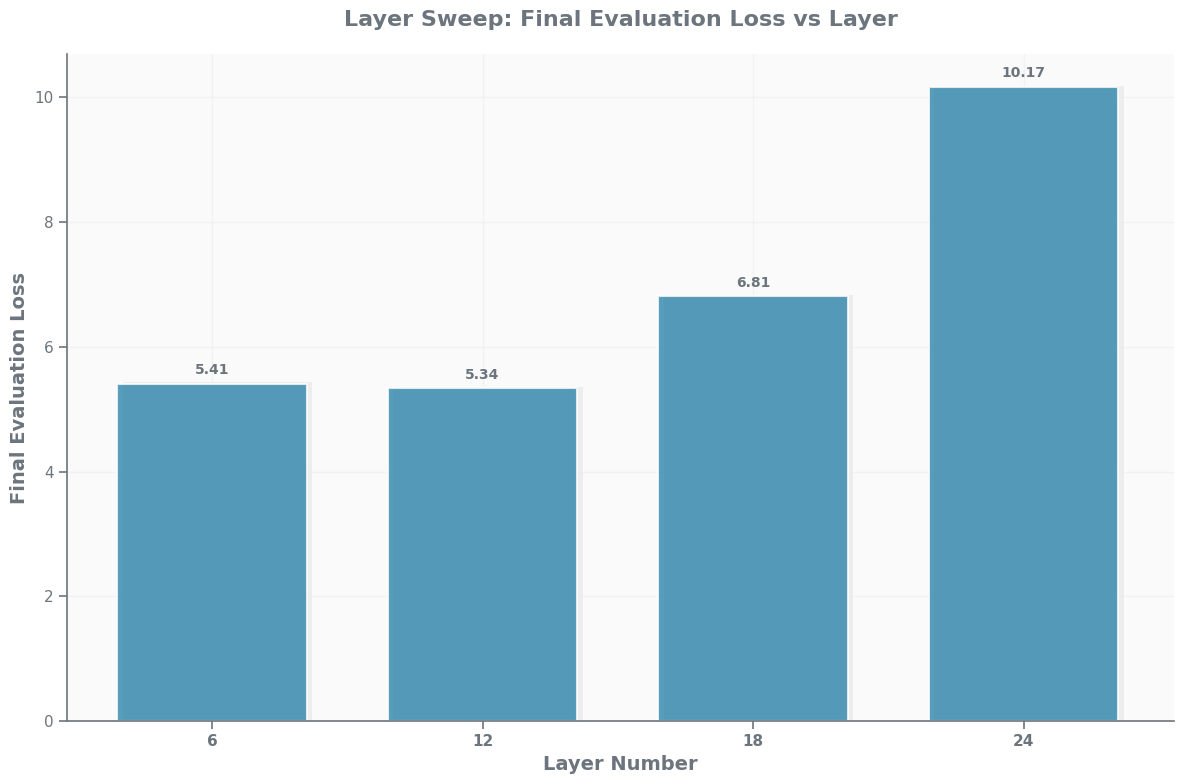


Datapoints: 4
Layer range: 6 to 24
Eval loss range: 5.3364 to 10.1697


In [17]:
fig3 = create_plot(
    data=layer_data,
    x_col='layer',
    y_col='eval_loss',
    title='Layer Sweep: Final Evaluation Loss vs Layer',
    xlabel='Layer Number',
    ylabel='Final Evaluation Loss',
    plot_type='bar'
)

if fig3:
    plt.show()
    
    # Print some statistics
    valid_data = layer_data.dropna(subset=['layer', 'eval_loss'])
    if len(valid_data) > 0:
        print(f"\nDatapoints: {len(valid_data)}")
        print(f"Layer range: {int(valid_data['layer'].min())} to {int(valid_data['layer'].max())}")
        print(f"Eval loss range: {valid_data['eval_loss'].min():.4f} to {valid_data['eval_loss'].max():.4f}")

## Plot 4: Layer Sweep - train/steering_vector/l0_norm_sparsity vs layer

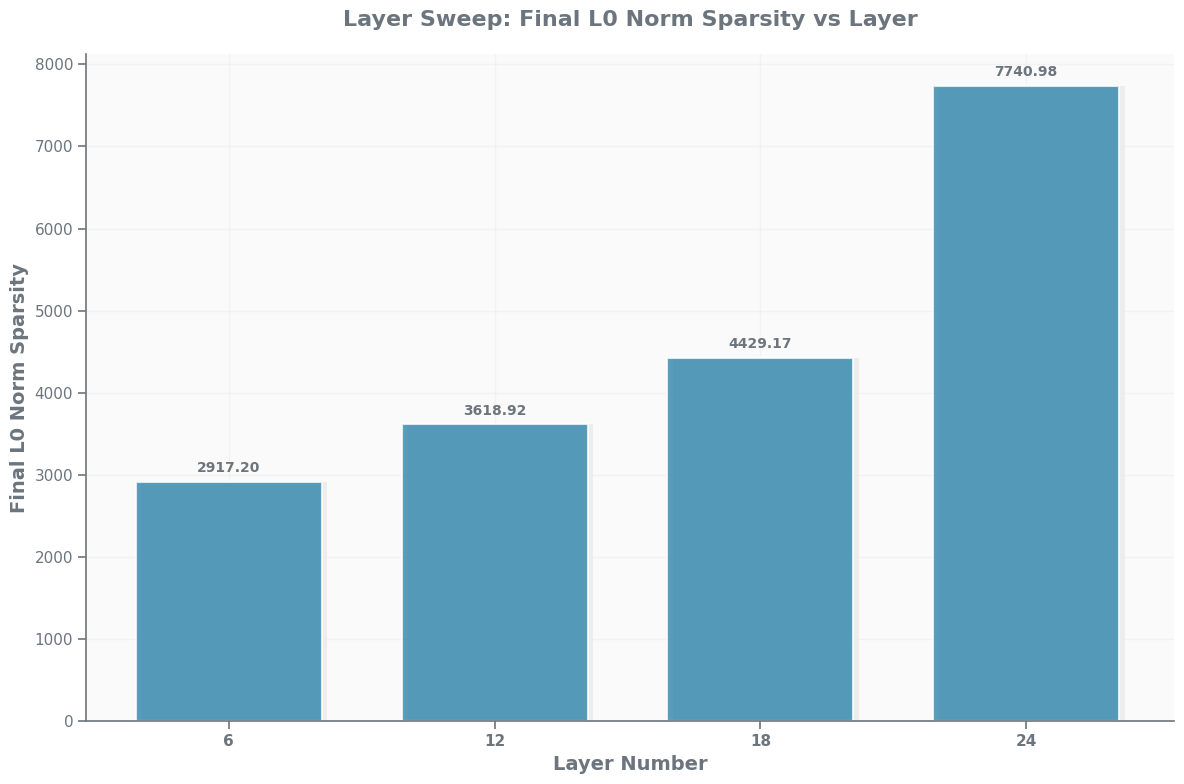


Datapoints: 4
Layer range: 6 to 24
L0 sparsity range: 2917.2014 to 7740.9844


In [18]:
fig4 = create_plot(
    data=layer_data,
    x_col='layer',
    y_col='train_l0_norm_sparsity',
    title='Layer Sweep: Final L0 Norm Sparsity vs Layer',
    xlabel='Layer Number',
    ylabel='Final L0 Norm Sparsity',
    plot_type='bar'
)

if fig4:
    plt.show()
    
    # Print some statistics
    valid_data = layer_data.dropna(subset=['layer', 'train_l0_norm_sparsity'])
    if len(valid_data) > 0:
        print(f"\nDatapoints: {len(valid_data)}")
        print(f"Layer range: {int(valid_data['layer'].min())} to {int(valid_data['layer'].max())}")
        print(f"L0 sparsity range: {valid_data['train_l0_norm_sparsity'].min():.4f} to {valid_data['train_l0_norm_sparsity'].max():.4f}")

## Summary Statistics and Data Export

In [19]:
# Summary of all collected data
print("=== DATA SUMMARY ===")
print(f"Total runs collected: {len(df)}")
print(f"Original sparsity sweep runs: {len(sparsity_data)}")
print(f"Original layer sweep runs: {len(layer_data)}")
print(f"Combined sparsity analysis runs: {len(combined_sparsity_data)}")

print("\n=== MISSING DATA ANALYSIS ===")
missing_eval_loss = df['eval_loss'].isna().sum()
missing_l0_sparsity = df['train_l0_norm_sparsity'].isna().sum()
missing_l1_coeff = df['l1_act_coeff'].isna().sum()
missing_layer = df['layer'].isna().sum()

print(f"Runs missing eval_loss: {missing_eval_loss}/{len(df)}")
print(f"Runs missing l0_norm_sparsity: {missing_l0_sparsity}/{len(df)}")
print(f"Runs missing l1_act_coeff: {missing_l1_coeff}/{len(df)}")
print(f"Runs missing layer info: {missing_layer}/{len(df)}")

=== DATA SUMMARY ===
Total runs collected: 8
Original sparsity sweep runs: 4
Original layer sweep runs: 4
Combined sparsity analysis runs: 5

=== MISSING DATA ANALYSIS ===
Runs missing eval_loss: 0/8
Runs missing l0_norm_sparsity: 0/8
Runs missing l1_act_coeff: 0/8
Runs missing layer info: 0/8


In [20]:
# Save data to CSV for further analysis
output_dir = "outputs"
os.makedirs(output_dir, exist_ok=True)

# Save full dataset
df.to_csv(f"{output_dir}/wandb_results_full.csv", index=False)
print(f"Full dataset saved to {output_dir}/wandb_results_full.csv")

# Save combined sparsity data
combined_sparsity_data.to_csv(f"{output_dir}/combined_sparsity_results.csv", index=False)
print(f"Combined sparsity data saved to {output_dir}/combined_sparsity_results.csv")

# Save layer data
layer_data.to_csv(f"{output_dir}/layer_sweep_results.csv", index=False)
print(f"Layer sweep data saved to {output_dir}/layer_sweep_results.csv")

Full dataset saved to outputs/wandb_results_full.csv
Combined sparsity data saved to outputs/combined_sparsity_results.csv
Layer sweep data saved to outputs/layer_sweep_results.csv


## Additional Analysis (Optional)

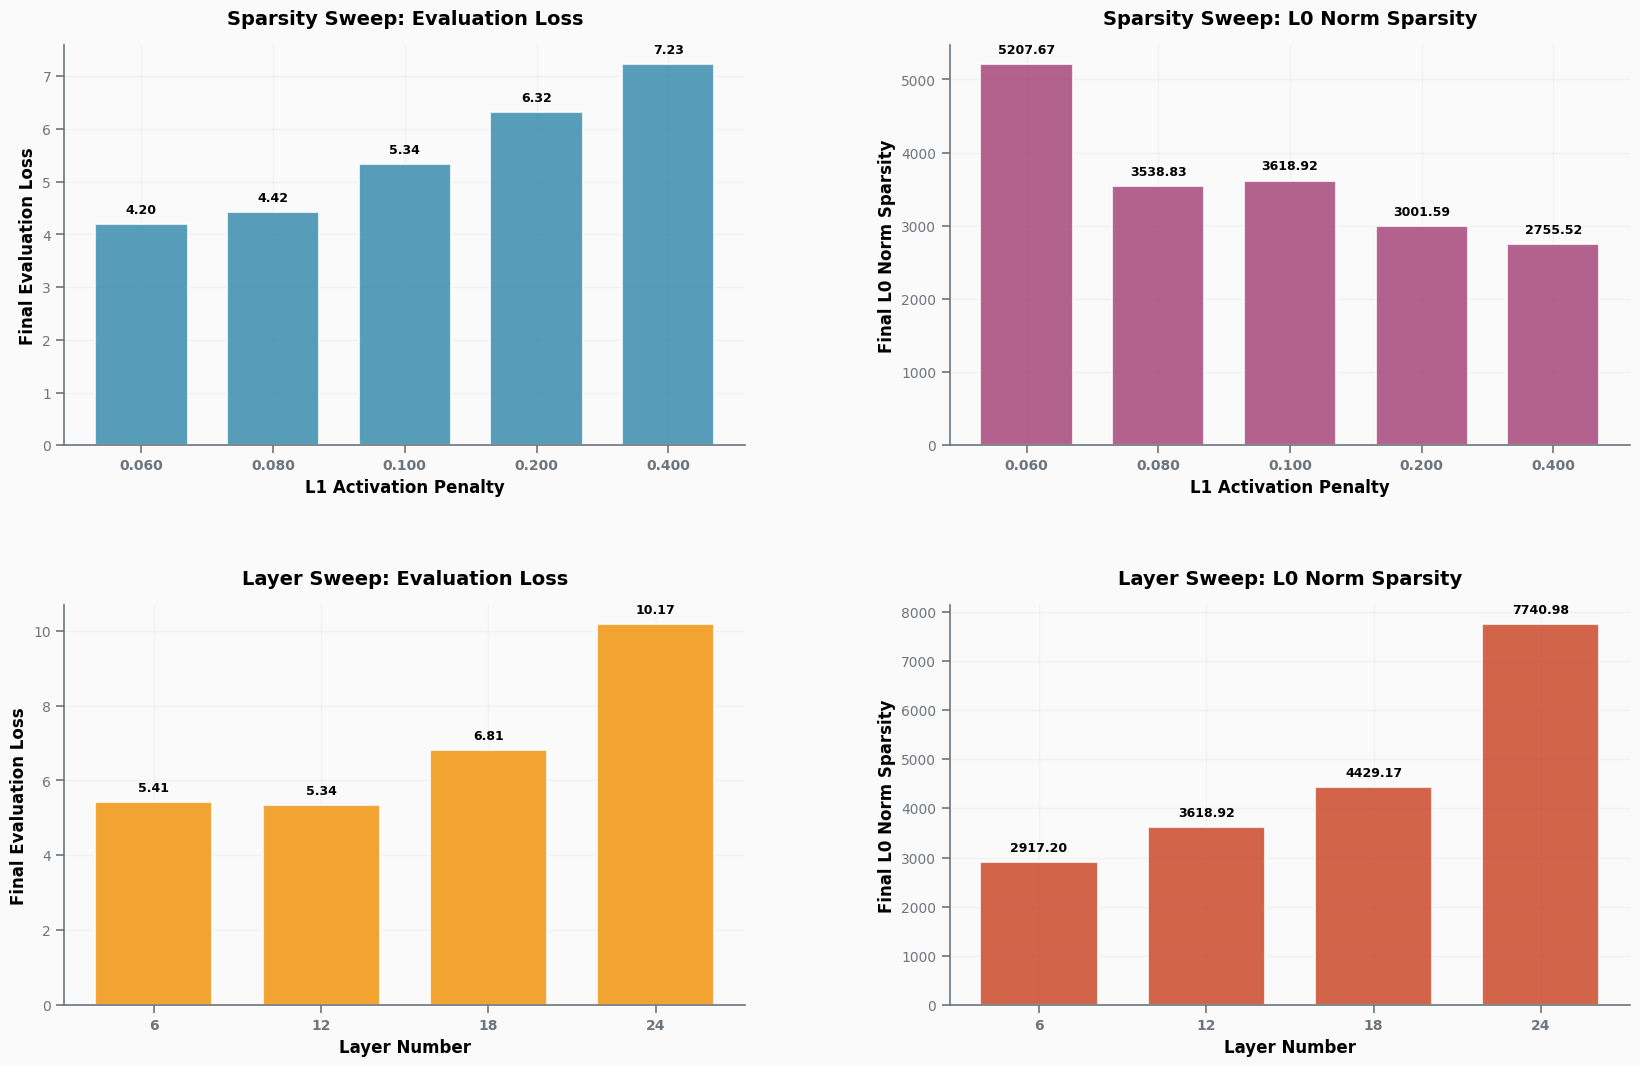

Combined plot saved to:
  - outputs/combined_results_plot.png
  - outputs/combined_results_plot.pdf


In [21]:
# Create a sophisticated combined plot showing all 4 analyses
fig = plt.figure(figsize=(18, 12))
fig.patch.set_facecolor('#FAFAFA')  # Set consistent background color

# Create a 2x2 grid with more spacing to prevent title overlap
gs = fig.add_gridspec(2, 2, hspace=0.4, wspace=0.3, 
                      left=0.08, right=0.95, top=0.88, bottom=0.08)

# Define a sophisticated color scheme for each plot
plot_colors = [colors['primary'], colors['secondary'], colors['accent'], colors['success']]
plot_alphas = [0.8, 0.8, 0.8, 0.8]

# Plot 1: Combined sparsity data - eval loss
ax1 = fig.add_subplot(gs[0, 0])
sparsity_eval_data = combined_sparsity_data.dropna(subset=['l1_act_coeff', 'eval_loss'])
if len(sparsity_eval_data) > 0:
    grouped_data = sparsity_eval_data.groupby('l1_act_coeff')['eval_loss'].mean().sort_index()
    x_positions = np.arange(len(grouped_data))
    
    bars = ax1.bar(x_positions, grouped_data.values, 
                   width=0.7, color=plot_colors[0], alpha=plot_alphas[0],
                   edgecolor='white', linewidth=1.5)
    
    # Add value labels without gradient effect, rounded to 2 decimal places
    for i, (bar, value) in enumerate(zip(bars, grouped_data.values)):
        ax1.text(bar.get_x() + bar.get_width()/2, value + max(grouped_data.values) * 0.02,
                f'{value:.2f}', ha='center', va='bottom', fontweight='bold', fontsize=9)
    
    ax1.set_xticks(x_positions)
    ax1.set_xticklabels([f'{x:.3f}' for x in grouped_data.index], fontweight='bold')
    ax1.set_xlabel('L1 Activation Penalty', fontsize=12, fontweight='bold')
    ax1.set_ylabel('Final Evaluation Loss', fontsize=12, fontweight='bold')
    ax1.set_title('Sparsity Sweep: Evaluation Loss', fontsize=14, fontweight='bold', pad=15)

# Plot 2: Combined sparsity data - l0 sparsity
ax2 = fig.add_subplot(gs[0, 1])
sparsity_l0_data = combined_sparsity_data.dropna(subset=['l1_act_coeff', 'train_l0_norm_sparsity'])
if len(sparsity_l0_data) > 0:
    grouped_data = sparsity_l0_data.groupby('l1_act_coeff')['train_l0_norm_sparsity'].mean().sort_index()
    x_positions = np.arange(len(grouped_data))
    
    bars = ax2.bar(x_positions, grouped_data.values, 
                   width=0.7, color=plot_colors[1], alpha=plot_alphas[1],
                   edgecolor='white', linewidth=1.5)
    
    # Add value labels without gradient effect, rounded to 2 decimal places
    for i, (bar, value) in enumerate(zip(bars, grouped_data.values)):
        ax2.text(bar.get_x() + bar.get_width()/2, value + max(grouped_data.values) * 0.02,
                f'{value:.2f}', ha='center', va='bottom', fontweight='bold', fontsize=9)
    
    ax2.set_xticks(x_positions)
    ax2.set_xticklabels([f'{x:.3f}' for x in grouped_data.index], fontweight='bold')
    ax2.set_xlabel('L1 Activation Penalty', fontsize=12, fontweight='bold')
    ax2.set_ylabel('Final L0 Norm Sparsity', fontsize=12, fontweight='bold')
    ax2.set_title('Sparsity Sweep: L0 Norm Sparsity', fontsize=14, fontweight='bold', pad=15)

# Plot 3: Layer sweep - eval loss
ax3 = fig.add_subplot(gs[1, 0])
layer_eval_data = layer_data.dropna(subset=['layer', 'eval_loss'])
if len(layer_eval_data) > 0:
    grouped_data = layer_eval_data.groupby('layer')['eval_loss'].mean().sort_index()
    x_positions = np.arange(len(grouped_data))
    
    bars = ax3.bar(x_positions, grouped_data.values, 
                   width=0.7, color=plot_colors[2], alpha=plot_alphas[2],
                   edgecolor='white', linewidth=1.5)
    
    # Add value labels without gradient effect, rounded to 2 decimal places
    for i, (bar, value) in enumerate(zip(bars, grouped_data.values)):
        ax3.text(bar.get_x() + bar.get_width()/2, value + max(grouped_data.values) * 0.02,
                f'{value:.2f}', ha='center', va='bottom', fontweight='bold', fontsize=9)
    
    ax3.set_xticks(x_positions)
    ax3.set_xticklabels([str(int(x)) for x in grouped_data.index], fontweight='bold')
    ax3.set_xlabel('Layer Number', fontsize=12, fontweight='bold')
    ax3.set_ylabel('Final Evaluation Loss', fontsize=12, fontweight='bold')
    ax3.set_title('Layer Sweep: Evaluation Loss', fontsize=14, fontweight='bold', pad=15)

# Plot 4: Layer sweep - l0 sparsity
ax4 = fig.add_subplot(gs[1, 1])
layer_l0_data = layer_data.dropna(subset=['layer', 'train_l0_norm_sparsity'])
if len(layer_l0_data) > 0:
    grouped_data = layer_l0_data.groupby('layer')['train_l0_norm_sparsity'].mean().sort_index()
    x_positions = np.arange(len(grouped_data))
    
    bars = ax4.bar(x_positions, grouped_data.values, 
                   width=0.7, color=plot_colors[3], alpha=plot_alphas[3],
                   edgecolor='white', linewidth=1.5)
    
    # Add value labels without gradient effect, rounded to 2 decimal places
    for i, (bar, value) in enumerate(zip(bars, grouped_data.values)):
        ax4.text(bar.get_x() + bar.get_width()/2, value + max(grouped_data.values) * 0.02,
                f'{value:.2f}', ha='center', va='bottom', fontweight='bold', fontsize=9)
    
    ax4.set_xticks(x_positions)
    ax4.set_xticklabels([str(int(x)) for x in grouped_data.index], fontweight='bold')
    ax4.set_xlabel('Layer Number', fontsize=12, fontweight='bold')
    ax4.set_ylabel('Final L0 Norm Sparsity', fontsize=12, fontweight='bold')
    ax4.set_title('Layer Sweep: L0 Norm Sparsity', fontsize=14, fontweight='bold', pad=15)

# Apply consistent styling to all subplots with more visible grids
for ax in [ax1, ax2, ax3, ax4]:
    # Enhanced grid with increased visibility
    ax.grid(True, alpha=0.5, linestyle='-', linewidth=1.0, color=colors['light'])
    ax.set_axisbelow(True)
    ax.set_facecolor('#FAFAFA')
    
    # Remove top and right spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_linewidth(1.2)
    ax.spines['left'].set_linewidth(1.2)
    ax.spines['bottom'].set_color(colors['neutral'])
    ax.spines['left'].set_color(colors['neutral'])
    
    # Enhanced tick styling
    ax.tick_params(axis='both', which='major', labelsize=10, 
                   colors=colors['neutral'], width=1.2, length=6)

# Add an overall title with better positioning to avoid overlap
# fig.suptitle('Feature Steering RL: Training Results Analysis', 
#              fontsize=20, fontweight='bold', color=colors['neutral'], y=0.95)

# # Add a subtle subtitle
# fig.text(0.5, 0.91, 'Comprehensive Analysis of Sparsity and Layer Sweep Experiments', 
#          ha='center', fontsize=12, color=colors['neutral'], style='italic')

# Save as PNG
plt.savefig(f"{output_dir}/combined_results_plot.png", dpi=300, bbox_inches='tight', 
            facecolor='#FAFAFA', edgecolor='none')

# Save as PDF (high quality vector format)
plt.savefig(f"{output_dir}/combined_results_plot.pdf", format='pdf', bbox_inches='tight', 
            facecolor='#FAFAFA', edgecolor='none')

plt.show()

print(f"Combined plot saved to:")
print(f"  - {output_dir}/combined_results_plot.png")
print(f"  - {output_dir}/combined_results_plot.pdf")